In [ ]:
import os
import sys
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [ ]:
!pip3 install pyro-ppl

     |████████████████████████████████| 678 kB 8.3 MB/s 


In [ ]:
import numpy as np

import scipy.stats
from scipy.stats import norm

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

%matplotlib inline
import torch
from torch.distributions import constraints

import pyro
import pyro.infer
import pyro.optim as optim
import pyro.distributions as dist

pyro.set_rng_seed(101)
torch.manual_seed(101)
np.random.seed(12);

In [ ]:
n = 100
x = np.random.randn(n,1)
std = 4
mu = -1
x = x * std + mu

print(f"Shape: {x.shape}")
print(f"Mean: {np.mean(x)}")
print(f"Standard deviation: {np.std(x)}")

Shape: (100, 1)
Mean: -0.9649572533206396
Standard deviation: 3.7704214957025473


In [ ]:
# x

In [ ]:
x=x.reshape(n)

In [ ]:
x.shape

(100,)

In [ ]:
x=torch.tensor(x)

In [ ]:
x.shape

torch.Size([100])

In [ ]:
pyro.distributions.enable_validation(False)

In [ ]:
def data_model(params):
  mu_dist = pyro.sample("mu_dist", dist.Normal(torch.tensor(params[0]), torch.tensor(params[1])))
  std_dist = pyro.sample(
      "std_dist", dist.Gamma(torch.tensor(np.abs(params[2])), torch.tensor(np.abs(params[3])))
  )
  # with pyro.plate("observed_data", size=len(X)):
  #       sample = pyro.sample("gaussian_data", dist.Normal(mu, 1/torch.sqrt(tau)), obs=X)
  # print("no")
  # print(mu_dist,std_dist)
  sample=0
  with pyro.plate("observation_dist",size=len(x)):
    sample=pyro.sample("data_dist",dist.Normal(mu_dist, std_dist),obs=x)
  return sample


# conditioned_data_model = pyro.condition(
#     data_model, data={"data_dist": torch.tensor(x.flatten())}
# )

In [ ]:
# def data_model(params):
#     mu_dist = pyro.sample("mu_dist", dist.Normal(params[0], params[1]))
#     std_dist = pyro.sample(
#         "std_dist", dist.Gamma(np.abs(params[2]), np.abs(params[3]))
#     )
#     return pyro.sample("data_dist", dist.Normal(mu_dist, std_dist))


# conditioned_data_model = pyro.condition(
#     data_model, data={"data_dist": torch.tensor(x)}
# )

In [ ]:
def parametrised_guide(params):
  mu_mu = pyro.param("mu_mu", torch.tensor(params[0]))
  mu_std = pyro.param(
      "mu_std", torch.tensor(params[1]), constraint=constraints.positive
  )
  std_a = pyro.param(
      "std_a", torch.tensor(params[2]), constraint=constraints.positive
  )
  std_b = pyro.param(
      "std_b", torch.tensor(params[3]), constraint=constraints.positive
  )

  mu_dist = pyro.sample("mu_dist", dist.Normal(mu_mu, mu_std))
  std_dist = pyro.sample("std_dist", dist.Gamma(std_a, std_b))
  # print("yes")
  # print(mu_dist,std_dist)
  
  return pyro.sample("data_dist", dist.Normal(mu_dist, std_dist))

In [ ]:
adam_params = {"lr": 0.3, "betas": (0.95, 0.999)}

# pyro.optim.SGD({"lr": 0.0001, "momentum": 0.9})
optimizer = pyro.optim.Adam(adam_params)
svi = pyro.infer.SVI(
  model=data_model,
  guide=parametrised_guide,
  optim=optimizer,
  loss=pyro.infer.Trace_ELBO(),
)

In [ ]:
mu_prior = [0.0, 10.0]  # Gaussian - mu, std
std_prior = [1.0, 0.1]  # Gamma - a, b
params_prior = mu_prior + std_prior

print(params_prior)

# params_prior=torch.tensor(params_prior)
print(params_prior)
# Iterate over all the data
losses, mu_mu, mu_std, std_a, std_b = [], [], [], [], []
pyro.clear_param_store()

[0.0, 10.0, 1.0, 0.1]
[0.0, 10.0, 1.0, 0.1]


In [ ]:
num_steps = 5000
for t in range(num_steps):
  loss=svi.step(params_prior)
  losses.append(loss)
  mu_mu.append(pyro.param("mu_mu").item())
  mu_std.append(pyro.param("mu_std").item())
  std_a.append(pyro.param("std_a").item())
  std_b.append(pyro.param("std_b").item())
  if (t%100==0):
    print("{}  {}".format(t,loss))

/usr/local/lib/python3.7/dist-packages/pyro/util.py:289: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'data_dist'}
  guide_vars - aux_vars - model_vars


0  42759.22332053028
100  873.3904633153884
200  683.0015059367879
300  605.3812797556224
400  525.569802015094
500  399.3969756891663
600  326.3080338875209
700  354.90801757664343
800  294.6100984503196
900  306.04359678435964
1000  282.95143113827714
1100  456.68188510092546
1200  286.1098047505621
1300  332.1329225045455
1400  280.60491947796004
1500  287.7334063392784
1600  279.87583027010334
1700  421.69512285807446
1800  275.2764377347747
1900  281.95649356845735
2000  282.72138925179206
2100  278.1546367764883
2200  284.26020899433047
2300  290.7251926104258
2400  280.242790178859
2500  278.03862210868033
2600  283.157852010458
2700  289.6533569608065
2800  278.4774530021065
2900  302.1541815548395
3000  295.7600426791035
3100  276.3694150598285
3200  276.60643432286633
3300  278.7017634336397
3400  283.88403285560355
3500  280.3738766953596
3600  278.1297188689971
3700  277.9299250390163
3800  278.84397560659727
3900  277.786234426632
4000  279.30252079571096
4100  278.7410191

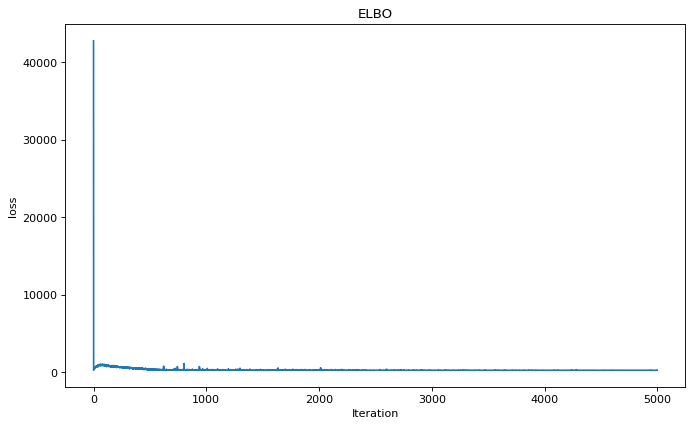

In [ ]:

# Convergence of the loss function
plt.figure(num=None, figsize=(10, 6), dpi=80)
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("Iteration")
plt.ylabel("loss")
# plt.savefig("images/elbo.png")
plt.show()

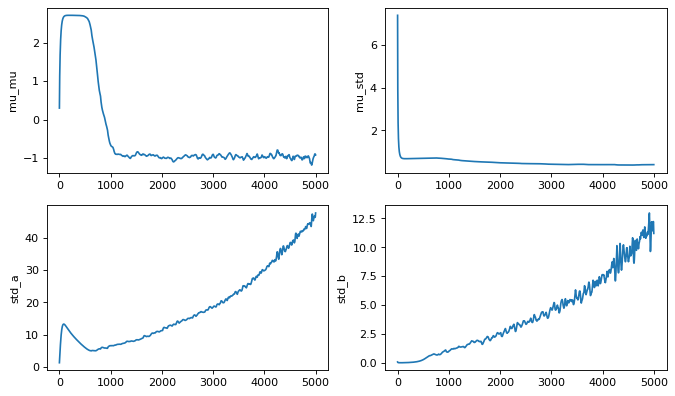

In [ ]:
plt.figure(num=None, figsize=(10, 6), dpi=80)
plt.subplot(2, 2, 1)
plt.plot(mu_mu)
plt.ylabel("mu_mu")

plt.subplot(2, 2, 2)
plt.ylabel("mu_std")
plt.plot(mu_std)

plt.subplot(2, 2, 3)
plt.ylabel("std_a")
plt.plot(std_a)

plt.subplot(2, 2, 4)
plt.ylabel("std_b")
plt.plot(std_b)
# plt.savefig("images/params.png")
plt.show()

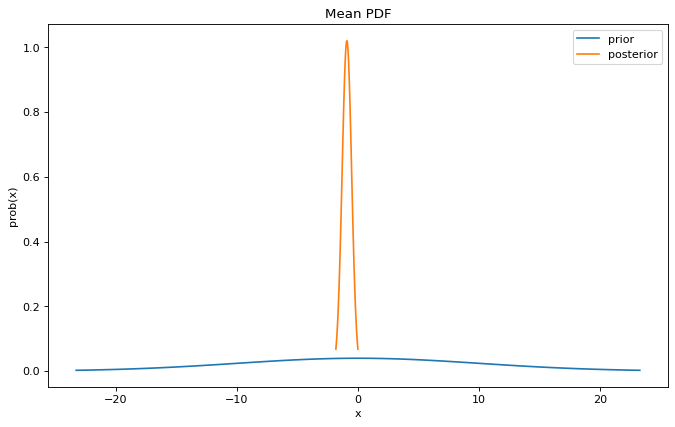

In [ ]:
# Plot mean distributions
plt.figure(num=None, figsize=(10, 6), dpi=80)
mu_prior_dist = norm(loc=mu_prior[0], scale=mu_prior[1])
x_range = np.linspace(mu_prior_dist.ppf(0.01), mu_prior_dist.ppf(0.99), num=100)
y_values = mu_prior_dist.pdf(x_range)
plt.plot(x_range, y_values, label="prior")

mu_post_dist = norm(loc=mu_mu[-1], scale=mu_std[-1])
x_range = np.linspace(mu_post_dist.ppf(0.01), mu_post_dist.ppf(0.99), num=100)
y_values = mu_post_dist.pdf(x_range)
plt.plot(x_range, y_values, label="posterior")

plt.xlabel("x")
plt.ylabel("prob(x)")
plt.title("Mean PDF")
plt.legend()
# plt.savefig("images/mean_dist.png")
plt.show()

In [ ]:
pyro.distributions.enable_validation(False)

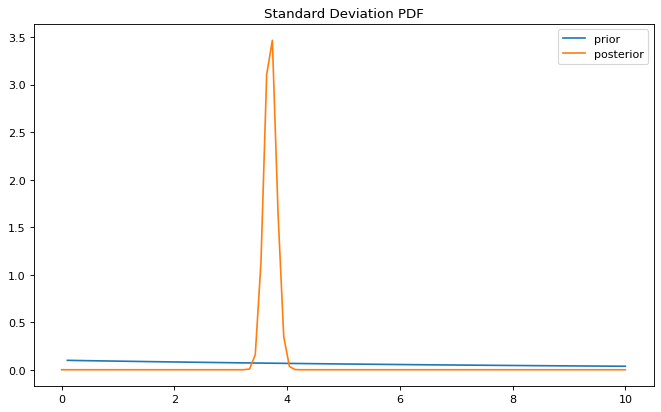

In [ ]:

# Plot std distributions
plt.figure(num=None, figsize=(10, 6), dpi=80)
x_range = np.linspace(0, 10, num=100)

std_prior_dist = dist.Gamma(std_prior[0], std_prior[1])
y_values = torch.exp(std_prior_dist.log_prob(x_range))
plt.plot(x_range, y_values, label="prior")

std_post_dist = dist.Gamma(std_a[-1], std_b[-1])
y_values = torch.exp(std_post_dist.log_prob(x_range))
plt.plot(x_range, y_values, label="posterior")

plt.title("Standard Deviation PDF")
plt.legend()
# plt.savefig("images/std_dist.png")
plt.show()

In [ ]:
import torch
import pyro

import matplotlib.pyplot as plt
import numpy as np

import pyro.infer
import pyro.optim
import pyro.distributions as dist
from torch.distributions import constraints



In [ ]:
n = 1000
x = np.random.randn(n, 1)
std = 4
mu = 2
x = x * std + mu

print(f"Shape: {x.shape}")
print(f"Mean: {np.mean(x)}")
print(f"Standard deviation: {np.std(x)}")


Shape: (1000, 1)
Mean: 1.912343282730119
Standard deviation: 3.9208018188088922


In [ ]:
def data_model(params):
    mu_dist = pyro.sample("mu_dist", dist.Normal(params[0], params[1]).independent(1))
    std_dist = pyro.sample(
        "std_dist", dist.Gamma(np.abs(params[2]), np.abs(params[3]).independent(1))
    )
    return pyro.sample("data_dist", dist.Normal(mu_dist, std_dist).independent(1))


conditioned_data_model = pyro.condition(
    data_model, data={"data_dist": torch.tensor(x.flatten())}
)

In [ ]:
def parametrised_guide(params):
    mu_mu = pyro.param("mu_mu", torch.tensor(params[0]))
    mu_std = pyro.param(
        "mu_std", torch.tensor(params[1]), constraint=constraints.positive
    )
    std_a = pyro.param(
        "std_a", torch.tensor(params[2]), constraint=constraints.positive
    )
    std_b = pyro.param(
        "std_b", torch.tensor(params[3]), constraint=constraints.positive
    )

    mu_dist = pyro.sample("mu_dist", dist.Normal(mu_mu, mu_std).independent(1))
    std_dist = pyro.sample("std_dist", dist.Gamma(std_a, std_b).independent(1))
    return pyro.sample("data_dist", dist.Normal(mu_dist, std_dist).independent(1))

In [ ]:
svi = pyro.infer.SVI(
    model=conditioned_data_model,
    guide=parametrised_guide,
    optim=pyro.optim.SGD({"lr": 0.00001, "momentum": 0.8}),
    loss=pyro.infer.Trace_ELBO(),
)

In [ ]:

mu_prior = [0.0, 10.0]  # Gaussian - mu, std
std_prior = [1.0, 0.1]  # Gamma - a, b
params_prior = mu_prior + std_prior

# Iterate over all the data
losses, mu_mu, mu_std, std_a, std_b = [], [], [], [], []
pyro.clear_param_store()

In [ ]:
num_steps = 5000
for t in range(num_steps):
    losses.append(svi.step(params_prior))
    mu_mu.append(pyro.param("mu_mu").item())
    mu_std.append(pyro.param("mu_std").item())
    std_a.append(pyro.param("std_a").item())
    std_b.append(pyro.param("std_b").item())

ValueError: ignored

('cloudy', 51.373016357421875)
('cloudy', 52.28388595581055)
('sunny', 70.28937530517578)
('cloudy', 35.4540901184082)
('sunny', 83.63148498535156)
('sunny', 75.91869354248047)
('sunny', 122.68901062011719)
('sunny', 58.44780731201172)
('sunny', 80.37315368652344)
('sunny', 101.10397338867188)


sunny 57.012847900390625
tensor(57.0450)


tensor(-165.0330)


In [ ]:
import numpy as np
import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.interpolate import interp1d
import numpy as np

In [ ]:
def line_intersection(line1, line2):
    '''
    Inputs: Two lines e.g., A(x1,y1) and B(x2,y2)
    Output: intersection of these two lines.
    '''
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    # print(div)
    if div == 0:
       raise Exception('lines do not intersect')
      # return "lines dont intersect"

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def make_line(p1, p2):
  '''
  Input: two points.
  Output: 2d numpy array depicting a line.
  '''
  return np.array([p1,p2])


def make_grid(list_of_vlines,list_of_hlines):
  '''
  Inputs: list of horizontal lines and list of vertical lines.
  Outputs: generates a grid of intersection of horizontal and vertical lines
  '''
  grid=[]
  for h in list_of_hlines:
    ls=[]
    for v in list_of_vlines:
      ls.append(line_intersection(h,v))
    grid.append(np.array(ls))
  return np.array(grid)


  '''
dx=[0,0,-1,1]
dy=[1,-1,0,0]



0 1 2 3
4 5 6 7
8 9 10 11
12 13 14 15
16 17 18 19

'''


def random_neigh_list():
  '''
  Generates two list randomly such that in grid I can either move L, R, U, D randomly.
  '''
  dx=[0,0,-1,1]
  dy=[]
  random.shuffle(dx)
  count=0
  for i in dx:
    if (i==0 and count==0):
      count=random.choice([-1,1])
      dy.append(count)
    elif (i==0):
      dy.append(-1*count)
    else:
      dy.append(0)
  return dx,dy

def cond(x,y,r,c):
  if (x<0 or y<0 or x>=r or y>=c):
    return False
  else:
    return True


def dfs(grid, node, parent, way_points, prev_way, width, total,tr):
  '''
  Does dfs to generate the waypoints, maintaining the lanes of the roads
  '''
  row=len(grid)
  col=len(grid[0])

  x,y=node//col,node%col
  tr.append([x,y])


  # x_offset,y_offset=0,0
  # # if (way=="R"):
  # #   x_offset=width/4
  # # elif (way=="L"):
  # #   x_offset=-width/4
  # # elif (way=="U"):
  # #   y_offset=width/4
  # # elif (way=="D"):
  # #   y_offset=-width/4
  
  # way_points.append([grid[x][y][0]+x_offset,grid[x][y][1]+y_offset,0])
  # print([grid[x][y]])
  
  if (len(way_points)>=total):
    return -1
  dx,dy=random_neigh_list()
  
  # print(x,y,len(way_points))
  # print(dx,dy)
  for i in range(0,4):
    xx,yy=x+dx[i],y+dy[i]
    new_node=xx*col+yy
    if (cond(xx,yy,row,col) and new_node!=parent):
      x_offset,y_offset=0,0
      if (dx[i]==0 and dy[i]==1):
        # right
        # print("right")
        if (prev_way=="U"):
          x_offset=-width/2
          y_offset=width/2
          way_points.append([grid[x][y][0]+x_offset,grid[x][y][1]+y_offset,0])
        
        if (prev_way=="R"):
          x_offset=width/2
          y_offset=width/2
          way_points.append([grid[x][y][0]+x_offset,grid[x][y][1]+y_offset,0])

        x_offset=width/2
        y_offset=-width/2
        prev_way="R"

      elif (dx[i]==0 and dy[i]==-1):
        # left
        # print("keft")
        if (prev_way=="D"):
          x_offset=width/2
          y_offset=-width/2
          way_points.append([grid[x][y][0]+x_offset,grid[x][y][1]+y_offset,0])
        
        if (prev_way=="L"):
          x_offset=-width/2
          y_offset=-width/2
          way_points.append([grid[x][y][0]+x_offset,grid[x][y][1]+y_offset,0])

        x_offset=-width/2
        y_offset=+width/2
        prev_way="L"

      elif (dx[i]==-1 and dy[i]==0):
        # up
        # print("up")
        if (prev_way=="L"):
          x_offset=-width/2
          y_offset=-width/2
          way_points.append([grid[x][y][0]+x_offset,grid[x][y][1]+y_offset,0])
        
        if (prev_way=="U"):
          x_offset=-width/2
          y_offset=width/2
          way_points.append([grid[x][y][0]+x_offset,grid[x][y][1]+y_offset,0])

        x_offset=width/2
        y_offset=width/2
        prev_way="U"

      elif (dx[i]==1 and dy[i]==0):
        # down
        if (prev_way=="D"):
          x_offset=width/2
          y_offset=-width/2
          way_points.append([grid[x][y][0]+x_offset,grid[x][y][1]+y_offset,0])
        
        if (prev_way=="R"):
          x_offset=width/2
          y_offset=width/2
          way_points.append([grid[x][y][0]+x_offset,grid[x][y][1]+y_offset,0])

        x_offset=-width/2
        y_offset=-width/2
        prev_way="D"
      
      # print(x,y,len(way_points))
      # print(dx,dy)
      if (len(way_points)>=total):
        return -1
      way_points.append([grid[x][y][0]+x_offset,grid[x][y][1]+y_offset,0])
      # print([grid[x][y]])
      # print([grid[x][y][0]+x_offset,grid[x][y][1]+y_offset])
      if (len(way_points)>=total or dfs(grid,new_node,node,way_points,prev_way,width,total,tr)==-1):
        return -1







In [ ]:

def convert_matlab(any_list):
  st="["
  count=0
  for ls in any_list:
    if (type(ls) is list):
      s=" ".join(map(str,ls))
    else:
      s=str(ls)
    if (count==len(any_list)-1):
      st+=s+"];\n"
    else:
      st+=s+";\n"
    count+=1
  return st



def generate_speed(n):
  return [random.uniform(20.0,70.0) for _ in range(n)]




def generate_more_points(hell):
  '''
  generates more waypoints along a line
  '''
  w_x=[]
  w_y=[]
  for i in range(0,len(hell),1):
    if (i==len(hell)-1):
      break
    x=hell[i:i+2,0]
    y=hell[i:i+2,1]

    # Linear length on the line
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, 5)
    x_regular, y_regular = fx(alpha), fy(alpha)

    if (i==0):
      w_x.extend(x_regular)
      w_y.extend(y_regular)
    else:
      w_x.extend(x_regular[1:])
      w_y.extend(y_regular[1:])

  w_x=np.array(w_x)
  w_y=np.array(w_y)
  w=np.stack([w_x,w_y,np.zeros(len(w_x))],axis=1)
  return w.tolist()




def print_car(file1, grid, width, total, count, ego):
  
  way_points,tr=[],[]

  # randomly choose one starting point for the car
  row,col=len(grid),len(grid[0])
  dfs(grid,random.randint(0,(row*col)-1),-1,way_points, "",width,total, tr)
  # print(way_points)
  # print(speed)
  position="["
  position+=" ".join(map(str,way_points[0]))
  position+="]"
  name="car"+str(count)
  # print(position)
  color="["+" ".join(map(str,[random.uniform(0,1) for _ in range(3)]))+"]"
  # print(color)
  
  # print("hell",way_points)


  way_points=generate_more_points(np.array(way_points))
  # print(way_points)
  speed=generate_speed(len(way_points))
  if ego:
    print("egoVehicle = vehicle(scenario, ... \n \t 'ClassID', 1, ... \n \t 'Position', {}, ... \n \t 'Mesh', driving.scenario.carMesh, ... \n \t 'PlotColor', {}, ...\n \t 'Name', 'Ego_car');".format(position,color))

  else:
    print("{} = vehicle(scenario, ... \n \t 'ClassID', 1, ... \n \t 'Position', {}, ... \n \t 'Mesh', driving.scenario.carMesh, ... \n \t 'PlotColor', {}, ...\n \t 'Name', '{}');".format(name,position,color,name))

  print("waypoints = {}".format(convert_matlab(way_points)))
  print("speed = {}".format(convert_matlab(speed)))

  if ego:
    print("trajectory(egoVehicle, waypoints, speed);\n")
  else:
    print("trajectory({}, waypoints, speed);\n".format(name))






def print_road(file1,line,width,road_name):
  # file1.write("roadCenters = ")
  print("roadCenters = [",end='')
  count=0
  for p in line:
    p=np.append(p,0)
    st=' '.join(map(str,p))
    if (count==len(line)-1):
      print(st+']'+';')
    else:
      print(st+';')
    count+=1
  print("marking = [laneMarking('Solid', 'Color', [0.98 0.86 0.36]) \n \t laneMarking('Solid') \n \t laneMarking('Solid')];")
  print("laneSpecification = lanespec(2, 'Width', {},'Marking', marking);".format(width))
  print("road(scenario, roadCenters, 'Lanes', laneSpecification, 'Name', '{}');\n".format(road_name))






# vl1=make_line((62.4,44.5),(-29.9,45.2))
# vl2=make_line((62.1,21.9),(-30.1,21.7))
# width=4.925
# total=10
# print("% Add all road segments")
# print_road(None,vl1,width,"hello")
# print_road(None,vl2,width,"hello2")

# print_ego(None,grid,width,total,1,False)


# print(generate_speed(10))

In [ ]:

for driving_scenario in range(1,11):
  # Saving the reference of the standard output
  original_stdout = sys.stdout 

  file_name="scenario_{}.txt".format(driving_scenario)
  with open(file_name,'w') as f:
    sys.stdout = f
    print("function [scenario, egoVehicle] = createDrivingScenario()")
    print("% createDrivingScenario Returns the drivingScenario defined in the Designer")
    print("% Generated by MATLAB(R) 9.10 (R2021a) and Automated Driving Toolbox 3.3 (R2021a).")
    print("% Construct a drivingScenario object.")
    print("scenario = drivingScenario;\n")

    width=4.925
    total=20

    vl1=make_line((62.4,44.5),(-29.9,45.2))
    vl2=make_line((62.1,21.9),(-30.1,21.7))
    vl3=make_line((61.7,-1),(-30.7,-1.2))
    vl4=make_line((61.7,-24.8),(-30.5,-25.3))

    list_of_vlines=[vl1,vl2,vl3,vl4]
    # print ("Vertical Lines")
    # print(list_of_vlines)


    hl1=make_line((57.8,49.7),(56.9,-29.8))
    hl2=make_line((37,49.7),(36.1,-29.8))
    hl3=make_line((14.3,50.1),(13.4,-29.4))
    hl4=make_line((-6.1,49.8),(-7,-29.7))
    hl5=make_line((-24.9,49.8),(-25.8,-29.7))

    list_of_hlines=[hl1,hl2,hl3,hl4,hl5]
    # print("Horizontal lines")
    # print(list_of_hlines)


    # Write the road information
    print("% Add all road segments")
    road_count=0
    for rd in list_of_vlines+list_of_hlines:
      road_count+=1
      print_road(None,rd,width,"Road"+str(road_count))


    # Make the grid
    grid=make_grid(list_of_vlines,list_of_hlines)
    # print("Grid")
    # print(grid)


    # Add ego vehicle
    print("% Add the ego vehicle")
    # file1, grid, width, total, count, ego
    print_car(None,grid,width,total,1,True)

    number_of_vehicles=3

    # Add other car
    print("% Add the non-ego actors")
    for v in range(1,number_of_vehicles+1):
      print_car(None,grid,width,total,v,False)
    sys.stdout = original_stdout 





In [ ]:
waypoints

NameError: ignored

In [ ]:
from scipy.interpolate import interp1d
import numpy as np


x = [0, 1, 8, 2, 2]
y = [1, 0, 6, 7, 2]

# Linear length on the line
distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
distance = distance/distance[-1]

fx, fy = interp1d( distance, x ), interp1d( distance, y )

alpha = np.linspace(0, 1, 15)
x_regular, y_regular = fx(alpha), fy(alpha)

plt.plot(x, y, 'o-');
plt.plot(x_regular, y_regular, 'or');
plt.axis('equal');

In [ ]:
[58.972782033881685 44.53532965954802 0;
58.716419692703134 21.889989522109982 0;
57.2259281040947 -2.2409341383028254 0;
37.65666841260507 -1.0547068865528029 0;
36.15503550743917 -23.707280176206947 0;
55.725062547326196 -24.825724986185868 0;
55.994678104094696 -1.0096841383028254 0;
56.25391969270313 21.889989522109982 0;
57.74153203388168 43.304079659548016 0;
38.174567689766825 44.693062596068934 0

In [ ]:
[57.74153203388168 43.304079659548016 0;
36.94331768976682 43.46181259606893 0;
14.240738545311835 43.633988169212145 0;
-6.154114203486279 43.78866202537854 0;
-23.721250245282405 43.931228333387836 0;
-23.986743320345113 22.94184003618146 0;
-6.417531638316333 22.98262194872382 0;
13.979573025981892 23.026867295067206 0;
37.91590889556491 21.844869108233326 0;
37.65666841260507 -1.0547068865528029 0]